# A deep feedforward network with arbitrary depth

In this exercise we build a deep feedforward neural network to recognize handwrittne digits (the MNIST data). The code has many tweekable parameters, in particular the number and width of layers. But as you will see adding more layers slows down the convergence considerably.


The usual imports plus gzip and pickle to read the data

In [436]:
import numpy as np
import matplotlib.pyplot as plt
import random
import gzip
import pickle

Important to be able to diplay matplotlib plots inline in the notebook

In [437]:
%matplotlib inline

The data are in compressed pickle format. 

In [438]:
def load_dataset():
    with gzip.open("mnist.pkl.gz") as f:
        data=pickle._Unpickler(f)
        data.encoding='latin1'
        tr,_,te=data.load()
    X=tr[0]
    Y=tr[1]
    X=X.T
    Y=Y.reshape(1,len(Y))
    V=np.zeros((10,Y.shape[1]))
    for j in range(Y.shape[1]):
        V[Y[0,j],j]=1
        
    Y=V
    test_data=te[0]
    test_labels=te[1]
    test_data=test_data.T
    test_labels=test_labels.reshape(1,len(test_labels))
    return X,Y,test_data,test_labels


The activation function is sigmoid

In [439]:
def sigmoid(x):
    s = 1/(1+np.exp(-x))
    return s

This function plots some of the misclassified data in order for us to have an idea what when wrong.

In [440]:
def print_misclassified(test_data,test_labels,biases,weights):
    As=forward_propagation(test_data,biases,weights)
    output=As[-1]
    count=0
    fig=plt.figure()
    fig.tight_layout()
    plt.subplots_adjust( wspace=1, hspace=1)

    for i in range(output.shape[1]):
        label=np.argmax(output[:,i])
        if label != test_labels[0,i]:
            if count>40:
                break
            subfig=count%40+1
            count=count+1
            img=test_data[:,i].reshape(28,28)
            t=fig.add_subplot(4,10,subfig)
            #t.set_title(str(i))
            t.set_title(str(label))
            t.axes.get_xaxis().set_visible(False)
            t.axes.get_yaxis().set_visible(False)
            plt.imshow(img,cmap='gray_r')



Returns the number of correct predictions

In [441]:
def evaluate(test_data,biases,weights):
    As=forward_propagation(test_data,biases,weights)
    output=As[-1]
    count=0
    for i in range(output.shape[1]):
        if np.argmax(output[:,i])==test_labels[0,i]:
            count=count+1
    return count

The usual cross Entropy cost

In [442]:
def compute_cost(Y,b,w):
    
    m = Y.shape[1] # number of example

    # Compute the cross-entropy cost
    As=forward_propagation(X,b,w)
    # recall that As contains the "output" of all layers
    # including the input As[0] and the final output As[-1]
    output=As[-1]
    logprobs = np.log(output)*Y+np.log(1-output)*(1-Y)
    cost = -np.sum(logprobs)/m

    count=0
    for i in range(output.shape[1]):
        if (np.argmax(output[:,i])==np.argmax(Y[:,i])):
            count=count+1

    
    cost = np.squeeze(cost)     # makes sure cost is the dimension we expect. 
                                # E.g., turns [[17]] into 17 
    assert(isinstance(cost, float))
    
    return cost,count


The weights are initialized randomly and the biases are initially set to zero

In [443]:
def initialize_parameters(width):    
    weights=[]
    biases=[]
    numlayers=num_layers
    for i in range(len(width)-1):
        print("size {},{}".format(width[i+1],width[i]))
        w=np.random.randn(width[i+1],width[i])
        b=np.zeros((width[i+1],1))
        weights.append(w)
        biases.append(b)

    return biases,weights


Forward propagation over all the layers but also retain the intermediate results.
For example below As[0] is the input, As[1] is the output of the first layer,..., and As[-1] (the last) is the output

In [444]:
def forward_propagation(X,biases,weights):
    a=X
    As=[X]
    for w,b in zip(weights,biases):
       z=np.dot(w,a)+b
       a=sigmoid(z)
       As.append(a)

    return As

In [445]:
def backward_propagation(X,Y,biases,weights):

    As=forward_propagation(X,biases,weights)
    m = X.shape[1]
    
    nlayers=len(biases)
    dz=As[nlayers]-Y
#   uncomment below if you want to use mean squared error
#    dz=dz*As[nlayers]*(1-As[nlayers])
    gradb=[]
    gradw=[]
    for i in range(nlayers,0,-1):
        db=np.sum(dz,axis=1,keepdims=True)/m
        dw=np.dot(dz,As[i-1].T)/m
        dz=np.dot(weights[i-1].T,dz)*As[i-1]*(1-As[i-1])
        gradb.insert(0,db)
        gradw.insert(0,dw)
    
    return gradb,gradw

In [446]:
def update_parameters(biases,weights, gradb,gradw, learning_rate):


    for i in range(len(biases)):
        weights[i]=weights[i]-learning_rate*gradw[i]
        biases[i]=biases[i]-learning_rate*gradb[i]

    return biases,weights

Initialize the parameters


In [447]:
def GD(X, Y, test_data,width,batch_size,num_iterations, learning_rate,print_cost=False):

    #n_x=X.shape[0]
    #n_y=Y.shape[0]
    biases,weights=initialize_parameters(width)

    for i in range(0, num_iterations):
        cost,count = compute_cost(Y,biases,weights)
       
        for k in range(0,X.shape[1],batch_size):
            idx=[random.randint(0,Y.shape[1]-1) for s in range(batch_size)]
            yb=Y[:,idx]
            xb=X[:,idx]
            gradb,gradw=backward_propagation(xb,yb,biases,weights)
            biases,weights=update_parameters(biases,weights,gradb,gradw,learning_rate)    

        if i%1 ==0 : 
            print(len(weights))   
            count_test=evaluate(test_data,biases,weights)
            print ("Cost after iteration %i: %f" %(i, cost))
            print("count after iteration %i is %i" %(i,count))
            print("test count after iteration %i is %i" %(i,count_test))
    return biases,weights

In [448]:
X, Y,test_data,test_labels = load_dataset()
n_x=X.shape[0]
n_y=Y.shape[0]
width=[n_x,256,128,64,n_y]
biases,weights= GD(X, Y,test_data,width,batch_size=10,learning_rate=3,
                num_iterations =10, print_cost=True)


count=evaluate(test_data,biases,weights)
A=forward_propagation(X,biases,weights)
print(A[-1].shape)
print(len(A))


size 256,784
size 128,256
size 64,128
size 10,64
4
Cost after iteration 0: 26.941498
count after iteration 0 is 5555
test count after iteration 0 is 1135
4
Cost after iteration 1: 8.022558
count after iteration 1 is 5678
test count after iteration 1 is 1135
4
Cost after iteration 2: 6.616136
count after iteration 2 is 5678
test count after iteration 2 is 958
4
Cost after iteration 3: 6.947624
count after iteration 3 is 4951
test count after iteration 3 is 974
4
Cost after iteration 4: 9.095302
count after iteration 4 is 4842
test count after iteration 4 is 958
4
Cost after iteration 5: 8.011339
count after iteration 5 is 4951
test count after iteration 5 is 1135
4
Cost after iteration 6: 8.594422
count after iteration 6 is 5678
test count after iteration 6 is 982
4
Cost after iteration 7: 6.208337
count after iteration 7 is 4859
test count after iteration 7 is 1010
4
Cost after iteration 8: 7.891224
count after iteration 8 is 5101
test count after iteration 8 is 1135
4
Cost after itera

Prints some of the misclassified digits. The top on each digit shows the (wrong) prediction.

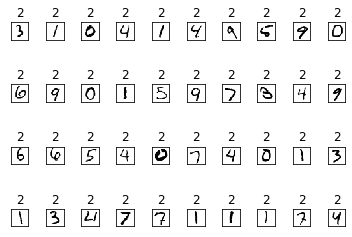

In [449]:
print_misclassified(test_data,test_labels,biases,weights)
